### The German Traffic Sign Benchmark

Student Name 1: Panagiotis Michalopoulos

Student Name 2: Filip Finfando

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
import numpy as np
import cv2

IMG_HEIGHT = 600
#SIGN_SIZE = (224, 224)
SIGN_SIZE = (32, 32)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + './../bin_labels_sorted.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [2]:
# use those numbers to change range in the next cell
! wc -l bin_labels_sorted.txt
! grep "00600.ppm" -B 5 -A 5 -m 1 bin_labels_sorted.txt --line-number

10213 bin_labels_sorted.txt
6848-00599.ppm;596;359;630;429;0
6849-00599.ppm;602;362;628;421;0
6850-00599.ppm;700;454;722;476;1
6851-00599.ppm;762;350;943;416;0
6852-00599.ppm;812;360;930;412;0
6853:00600.ppm;0;434;406;582;0
6854-00600.ppm;157;300;1020;600;0
6855-00600.ppm;1;423;97;512;0
6856-00600.ppm;2;420;158;518;0
6857-00600.ppm;458;423;476;452;0
6858-00600.ppm;494;427;518;453;0


In [3]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('./FullIJCNN2013', range(0,600), range(0,6852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('./FullIJCNN2013', range(600,900), range(6852,10213))

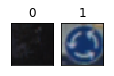

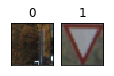

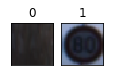

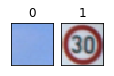

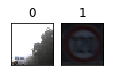

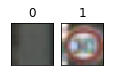

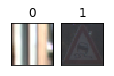

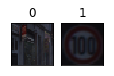

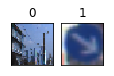

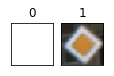

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)

for r in range(10):
    fig = plt.figure(figsize=(8,8))
    for i in range(num_classes):
        ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
        ax.set_title(class_names[i])
        indices = np.where(np.isin(train_labels, class_names[i]))[0]
        plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
    plt.show()

In [10]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:6000]
tr_labels = np.array(train_labels)[0:6000]
va_signs = np.array(train_signs)[6000:6852]
va_labels = np.array(train_labels)[6000:6852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [11]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.2: Convolutional Neural Network

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras import regularizers, optimizers
from keras.layers.normalization import BatchNormalization

cnn = Sequential()

cnn.add(Conv2D(filters=32, strides=(2, 2), kernel_size=(5, 5), padding='same', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), kernel_initializer='glorot_normal'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
cnn.add(Dropout(0.1))

cnn.add(Conv2D(filters=64, strides=(2, 2), kernel_size=(5, 5), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
cnn.add(Dropout(0.2))

cnn.add(Conv2D(filters=128, strides=(2, 2), kernel_size=(5, 5), padding='same'))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
cnn.add(Dropout(0.3))

cnn.add(Flatten())

#cnn.add(Dense(128, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.1)))
cnn.add(Dense(1024))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.7))
cnn.add(Dense(num_classes))
cnn.add(Activation('softmax'))

# cnn = Sequential()

# cnn.add(Conv2D(filters=16, strides=1, kernel_size=(3, 3), padding='same', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), kernel_initializer='glorot_normal'))
# cnn.add(Activation('relu'))

# cnn.add(Conv2D(filters=16, strides=1, kernel_size=(3, 3), padding='same'))
# cnn.add(Activation('relu'))

# cnn.add(MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'))
# cnn.add(Dropout(0.25))

# cnn.add(Flatten())

# cnn.add(Dense(128, kernel_initializer='glorot_normal'))
# cnn.add(Activation('relu'))
# cnn.add(Dropout(0.5))
# cnn.add(BatchNormalization())

# cnn.add(Dense(128, kernel_initializer='glorot_normal'))
# cnn.add(Activation('relu'))
# cnn.add(BatchNormalization())

# cnn.add(Dense(128, kernel_initializer='glorot_normal'))
# cnn.add(Activation('relu'))
# cnn.add(BatchNormalization())

# cnn.add(Dense(num_classes))
# cnn.add(Activation('softmax'))


opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 16, 16, 32)        2432      
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          51264     
_________________________________________________________________
activation_7 (Activation)    (None, 4, 4, 64)          0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 64)          0         
__________

In [13]:
data = cnn.fit(tr_signs, tr_labels, batch_size=128, epochs=100, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

Train on 6000 samples, validate on 852 samples
Epoch 1/100
 - 1s - loss: 0.3898 - acc: 0.8660 - val_loss: 0.3048 - val_acc: 0.8885
Epoch 2/100
 - 1s - loss: 0.2930 - acc: 0.8738 - val_loss: 0.1979 - val_acc: 0.8885
Epoch 3/100
 - 1s - loss: 0.1780 - acc: 0.9300 - val_loss: 0.1104 - val_acc: 0.9683
Epoch 4/100
 - 1s - loss: 0.0973 - acc: 0.9672 - val_loss: 0.0801 - val_acc: 0.9754
Epoch 5/100
 - 1s - loss: 0.0667 - acc: 0.9772 - val_loss: 0.0569 - val_acc: 0.9883
Epoch 6/100
 - 1s - loss: 0.0602 - acc: 0.9792 - val_loss: 0.0952 - val_acc: 0.9671
Epoch 7/100
 - 1s - loss: 0.0420 - acc: 0.9882 - val_loss: 0.0471 - val_acc: 0.9871
Epoch 8/100
 - 1s - loss: 0.0330 - acc: 0.9903 - val_loss: 0.0343 - val_acc: 0.9930
Epoch 9/100
 - 1s - loss: 0.0417 - acc: 0.9858 - val_loss: 0.0519 - val_acc: 0.9906
Epoch 10/100
 - 1s - loss: 0.0336 - acc: 0.9895 - val_loss: 0.0324 - val_acc: 0.9918
Epoch 11/100
 - 1s - loss: 0.0241 - acc: 0.9918 - val_loss: 0.0412 - val_acc: 0.9871
Epoch 12/100
 - 1s - loss: 

Epoch 97/100
 - 1s - loss: 0.0063 - acc: 0.9978 - val_loss: 0.0243 - val_acc: 0.9941
Epoch 98/100
 - 1s - loss: 0.0031 - acc: 0.9990 - val_loss: 0.0297 - val_acc: 0.9953
Epoch 99/100
 - 1s - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0215 - val_acc: 0.9941
Epoch 100/100
 - 1s - loss: 0.0081 - acc: 0.9975 - val_loss: 0.0337 - val_acc: 0.9930
CNN took 0.3134121894836426 seconds
Test loss: 0.01668302029463701 - Accuracy: 0.9970246950312407


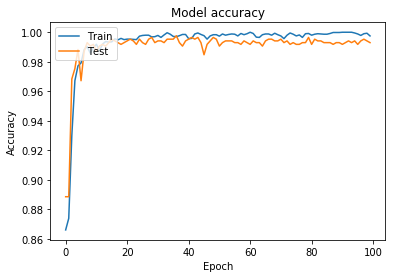

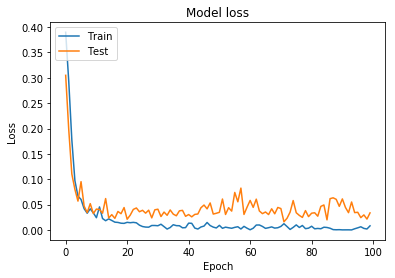

In [15]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
# serialize model to JSON
model_json = cnn.to_json()
with open("bin_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cnn.save_weights("bin_model.h5")
print("Saved model to disk")

Saved model to disk


6000
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
12000


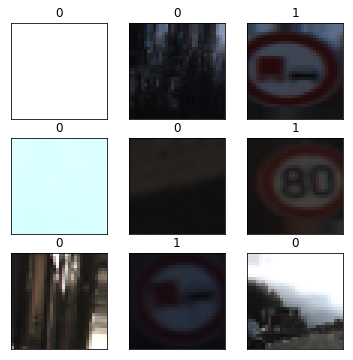

Epoch 1/100


KeyboardInterrupt: 

In [17]:
from keras.preprocessing.image import ImageDataGenerator

print(len(tr_signs))
tr_signs_old = np.array(tr_signs, copy=True) 
tr_labels_old = np.array(tr_labels, copy=True)

#datagen = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

datagen.fit(tr_signs, augment=True)

print(type(tr_signs_old))
print(type(tr_signs))

# Concatenating the old data with the augmented data
tr_signs  = np.concatenate((tr_signs, tr_signs_old), axis=0)
tr_labels  = np.concatenate((tr_labels, tr_labels_old), axis=0)

print(len(tr_signs))

for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break

train_steps = int(len(tr_signs) / 16)
valid_steps = int(len(va_signs) / 16)
data = cnn.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=16), epochs=100, steps_per_epoch=train_steps, verbose=2, validation_data=(va_signs, va_labels), validation_steps=valid_steps, callbacks=[tensorboard])

start = time()
loss, acc = cnn.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('CNN took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

In [ ]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()